In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pyproj 
from tqdm import tqdm
import reverse_geocoder as rg

from shapely.geometry import Point
from shapely.geometry import LineString

from preprocessing.pre_process_stations import *
from preprocessing.pre_process_traffic import *
from preprocessing.helping_functions import *

from features.config import *
from features.financials_part_2 import *
from features.question_1 import *
from features.question_2 import *

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
class Config:
    PATH = '../../data/'

class Params:
    PARAM = 0
config = Config()
p = Params()

## Load data

In [4]:
##### Load new coordinates
df_new_points = gpd.read_file(config.PATH+'new_coordinates/new_coordinates.shp')

##### Load hub data 
df_hub_dense = gpd.read_file(config.PATH+'F-aire-logistiques-donnees-detaillees/Aires_logistiques_denses.shp')
df_hub_enlarged = gpd.read_file(config.PATH+'F-aire-logistiques-donnees-detaillees/Aires_logistiques_elargies.shp')

In [5]:
##### Load traffic data
df_traffic = gpd.read_file(config.PATH+'E-tmja2019-shp/TMJA2019.shp')
df_traffic = preprocess_data(df_traffic)
df_traffic = fix_tmja(df_traffic)

Loading formatted geocoded file...


In [6]:
df_new_points = distance_to_hub(df_hub_dense, df_hub_enlarged, df_new_points)

100%|██████████| 13978/13978 [01:09<00:00, 200.38it/s]


In [7]:
df_traffic = df_traffic.groupby('route')[['TMJA_PL','percentage_traffic']].sum().reset_index(drop=False)

In [8]:
df_traffic['percentage_traffic'].sum()

1.0

In [9]:
df_new_points = df_new_points.merge(df_traffic, how='left', on='route')

In [10]:
def station_distances_all(
        df_stations: pd.DataFrame
):
    '''
    Add columns of the distances between each stations 
    '''

    for i in tqdm(df_stations['index']):
        station_index = df_stations.loc[i, 'index']
        df_stations[f'distance_to_point_{station_index}'] = df_stations.loc[i, 'geometry'].distance(df_stations['geometry'])

    return df_stations

In [11]:
df_new_points = station_distances_all(df_new_points)

100%|██████████| 13978/13978 [03:45<00:00, 61.95it/s]


## Genetic algorithm deap library


In [12]:
def sales(df_station:pd.DataFrame,year: float)-> pd.DataFrame:
    '''
    This functions calculates the amount sold at each new stations in kg/day.
    '''
    h2_price_dict = {2023: 10, 2030: 7, 2040: 4}
    if year not in h2_price_dict:
        raise ValueError('Year can only be 2023, 2030 or 2040')
    
    df_station['Quantity_sold_per_day(in kg)'] = total_demand * df_station['percentage_traffic'] *  (1 / df_station.groupby('route')['route'].transform('count'))
    df_station['Revenues_day'] = df_station['Quantity_sold_per_day(in kg)']  * h2_price_dict[year]

    return df_station

In [13]:
df_stations = sales(df_new_points,2030)

In [15]:
import random
import numpy as np
from deap import base, creator, tools

# Define the fitness function that takes a pandas DataFrame as input and returns a fitness score
def fitness(X,data: pd.DataFrame=df_stations):
    index = X[0]

    if type(index)==int:
        index = np.random.choice(list(range(13978)), size=376, replace=False)

    columns_distance = [c for c in data.columns if c.startswith('distance_to_point_')==True]
    if data.iloc[index,:].shape[0]>0:
        columns_distance_drop = [columns_distance[i] for i in index]
        data_sub = get_closer_station(data.iloc[index,:].drop(columns=columns_distance_drop))
        data_sub = data_sub[data_sub['distance_closer_station'] < 150000*0.8]
        # constraint profitability: make sure the station is profitable 
        fit = 150 - (data_sub['distance_to_closest_large_hub'].mean() + data_sub['distance_to_closest_dense_hub'].mean() - data_sub['distance_closer_station'].mean())/100 + data_sub['Revenues_day'].mean()

    else:
        fit = 10e10
        
    return fit

# Define the evaluation function
def evaluate(individual):
    return fitness(individual),

# Set up the DEAP toolbox
creator.create("FitnessMax", base.Fitness, weights=[1.0,])
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()

# Register the genetic operators
toolbox.register("individual", tools.initRepeat, creator.Individual, lambda: np.random.choice(list(range(3089)), size=376, replace=False),n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=3, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Set the number of generations and the population size
num_generations = 50
population_size = 100

# Create the initial population
population = toolbox.population(n=population_size)

# Evaluate the initial population
fitnesses = list(map(toolbox.evaluate, population))
for ind, fit in zip(population, fitnesses):        
    ind.fitness.values = fit

# Set up the hall of fame and statistics objects
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)
stats.register("min", np.min)
stats.register("argmin", np.argmin)

avg_fitness = []
min_fitness = []
max_fitness = []
arg_min_fitness = []

# Start the evolution process
for generation in tqdm(range(num_generations)):
    
    population = [x for x in population if type(x)!=int]

    # Select the next generation individuals
    offspring = toolbox.select(population, len(population))

    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if type(child1[0])==int:
            child1[0] = np.random.choice(list(range(3089)), size=376, replace=False)
        elif type(child1[0])==int:
            child2[0] = np.random.choice(list(range(3089)), size=376, replace=False)
        else:
            toolbox.mate(child1[0], child2[0])
        del child1.fitness.values
        del child2.fitness.values

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    # Evaluate the new individuals
    fresh_individuals = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, fresh_individuals)
    for ind, fit in zip(fresh_individuals, fitnesses):
        ind.fitness.values = fit

    # Add the new individuals to the population
    population[:] = offspring

    # Update the hall of fame and statistics
    #hof.update(population)
    record = stats.compile(population)
    print("Generation {}:".format(generation + 1))
    avg_fitness.append(record["avg"])
    min_fitness.append(record["min"])
    max_fitness.append(record["max"])
    arg_min_fitness.append(record["argmin"])

 10%|█         | 1/10 [01:02<09:22, 62.51s/it]

Generation 1:


 20%|██        | 2/10 [02:13<08:57, 67.23s/it]

Generation 2:


 30%|███       | 3/10 [03:32<08:28, 72.59s/it]

Generation 3:


 40%|████      | 4/10 [04:49<07:27, 74.52s/it]

Generation 4:


 50%|█████     | 5/10 [06:03<06:11, 74.29s/it]

Generation 5:


 60%|██████    | 6/10 [07:10<04:47, 71.91s/it]

Generation 6:


 70%|███████   | 7/10 [08:48<04:01, 80.39s/it]

Generation 7:


 80%|████████  | 8/10 [10:51<03:07, 93.93s/it]

Generation 8:


 90%|█████████ | 9/10 [12:28<01:34, 94.81s/it]

Generation 9:


100%|██████████| 10/10 [14:50<00:00, 89.07s/it] 

Generation 10:


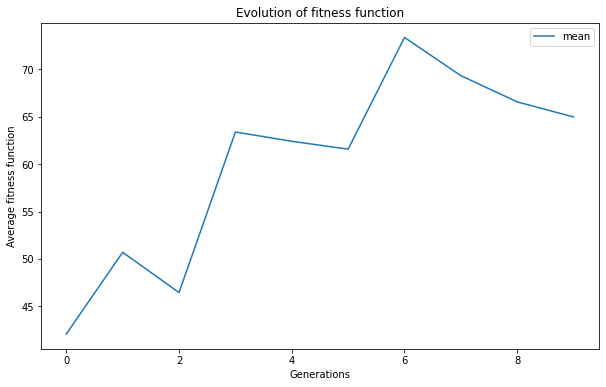

In [16]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.arange(len(avg_fitness)),avg_fitness,label='mean')
plt.xlabel('Generations')
plt.ylabel('Average fitness function')
plt.legend()
plt.title('Evolution of fitness function')
plt.show()

In [90]:
def extract_restults(
        population,
        max_fitness,
        df_stations
):
    best_gen = np.argmax(max_fitness)
    best_solution = population[best_gen][0]
    chosen_stations = pd.concat([df_stations.iloc[best_solution,:11],df_stations.iloc[best_solution,-2:]],axis=1)

    return chosen_stations

In [105]:
chosen_stations = extract_restults(
        population,
        max_fitness,
        df_stations
)

In [117]:
chosen_stations = sales(chosen_stations)

In [119]:
chosen_stations = station_type(chosen_stations)

In [120]:
chosen_stations

,index,easting,northing,route,geometry,closest_dense_hub,distance_to_closest_dense_hub,closest_elargie_hub,distance_to_closest_large_hub,TMJA_PL,percentage_traffic,Quantity_sold_per_day(in kg),Revenues_day,Quantity_sold_per_year(in kg),not_prof,small_station,medium_station,large_station,station_type
2009,2009,647882.498112361,6871707.6796159,A0015,POINT (647882.498 6871707.680),1.0,0 0.0 dtype: float64,5.0,0 0.0 dtype: float64,118449.40,0.009562,964.847349,6753.931441,352169.282288,0,0,0,1,large
2962,2962,485051.6717446413,6810574.914936585,A0028,POINT (485051.672 6810574.915),1.0,0 34797.622478 dtype: float64,5.0,0 6415.754284 dtype: float64,73035.72,0.005896,251.698365,1761.888556,91869.903303,0,0,0,1,large
1176,1176,970314.6355770391,6260898.838787425,A0008,POINT (970314.636 6260898.839),1.0,0 69337.586656 dtype: float64,5.0,0 13677.75309 dtype: float64,159447.95,0.012871,1098.990695,7692.934867,401131.603779,0,0,0,1,large
61,61,654443.5179221067,6870549.906443723,A0001,POINT (654443.518 6870549.906),1.0,0 0.0 dtype: float64,5.0,0 0.0 dtype: float64,333120.37,0.026890,1492.415058,10446.905407,544731.496236,0,0,0,1,large
682,682,672037.5967658103,6832667.3651473755,A0005A,POINT (672037.597 6832667.365),1.0,0 1908.133351 dtype: float64,5.0,0 0.0 dtype: float64,28160.18,0.002273,630.803164,4415.622148,230243.154834,0,0,0,1,large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2219,2219,661974.8928676986,7105084.957257127,A0016,POINT (661974.893 7105084.957),1.0,0 6186.407007 dtype: float64,5.0,0 5548.375172 dtype: float64,42708.41,0.003448,159.448556,1116.139889,58198.722785,0,0,0,1,large
1550,1550,498052.3198798554,6622504.179505058,A0010,POINT (498052.320 6622504.180),1.0,0 5212.308241 dtype: float64,5.0,0 859.494918 dtype: float64,381900.72,0.030828,1140.637512,7984.462587,416332.692032,0,0,0,1,large
1955,1955,517944.59791988606,6923117.646640384,A0013,POINT (517944.598 6923117.647),1.0,0 11042.402388 dtype: float64,5.0,0 2802.466653 dtype: float64,199619.88,0.016114,894.318516,6260.229609,326426.258204,0,0,0,1,large
727,727,688176.8054062742,6786713.428709412,A0006,POINT (688176.805 6786713.429),1.0,0 19835.803342 dtype: float64,5.0,0 11331.046813 dtype: float64,356928.98,0.028812,1390.504513,9733.531589,507534.147166,0,0,0,1,large


In [122]:
chosen_stations['station_type'].value_counts()

large             349
not profitable     27
Name: station_type, dtype: int64

In [102]:
finance_chosen_stations = financial_summary(chosen_stations)

In [88]:
finance_chosen_stations

station_type,large,not profitable
CAPEX,8.508005e+08,0.0
EBIT,8.508029e+08,0.0
EBITDA,7.775133e+08,0.0
Opex,7.329000e+07,0.0
Revenues,8.508033e+08,0.0
depreciation,-7.328958e+07,0.0
Total,3.329920e+09,0.0
